In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# The Data

In [2]:
data = pd.read_csv('new_dataset/owid-covid-data-most-recent.csv')
data = data.dropna(subset = ['new_deaths'])

# converting date to date object
data['date'] = pd.to_datetime(data['date'])

# dropping observations before COVID-19 was detected in the country
data = data[~data['total_cases'].isna()]

# dropping redundant columns like smoothed and similar predictors
columns_to_drop = ['new_cases_smoothed',
                   'new_cases_smoothed_per_million',
                   'total_deaths',
                   'total_deaths_per_million',
                   'new_deaths_per_million',
                   'new_deaths_smoothed',
                   'new_deaths_smoothed_per_million',
                   'excess_mortality_cumulative',
                   'excess_mortality_cumulative_absolute',
                   'excess_mortality_cumulative_per_million',
                   'icu_patients',
                   'hosp_patients',
                   'weekly_icu_admissions',
                   'weekly_hosp_admissions',
                   'total_tests',
                   'new_tests',
                   'new_tests_smoothed',
                   'new_tests_smoothed_per_thousand',
                   'tests_per_case', #this is the inverse of positive_rate
                   'new_vaccinations_smoothed',
                   'total_vaccinations',
                   'people_vaccinated',
                   'people_fully_vaccinated',
                   'total_boosters',
                   'new_vaccinations_smoothed_per_million',
                   'new_people_vaccinated_smoothed']
data = data.drop(columns_to_drop,axis=1)

# filtering countries by null values in other columns
null_counts = data.groupby('location').agg(lambda x: x.isnull().sum(axis=0))
# missing_counts = data.groupby('location').apply(lambda x: x.isnull().sum())
total_null = null_counts.sum(axis=1)
null_counts['total_null'] = null_counts.sum(axis=1)
#filtering top 10 countries 
sorted_countries = null_counts[['total_null']].sort_values(by = 'total_null',ascending=True)
top_df = sorted_countries.iloc[:10]
filtered_countries_list = top_df.index.to_list()
data = data[data['location'].isin(filtered_countries_list)]
print(data.shape)
total_missing_per_country = total_null
sorted_countries = total_missing_per_country.sort_values(ascending=True)
sorted_countries.head(10)

(2007, 41)


location
United States    1008
Estonia          1104
Italy            1191
Ireland          1285
Israel           1367
Czechia          1408
Malaysia         1465
Belgium          1514
Chile            1559
France           1583
dtype: int64

# Missingness

In [3]:
# filtering data for top 10 countries with least missingness
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result_df = pd.DataFrame()
    for country in data['location'].unique():
        country_data = data[data['location'] == country]
        missing_counts = country_data.isnull().sum()
        total_missing = missing_counts.sum()
        missingness_prop = total_missing / (len(country_data)*data.shape[1])
        result_df = result_df.append({'location': country, 'total_missing': total_missing, 'missingness_prop': missingness_prop}, ignore_index=True)
    
    sorted_countries = result_df.sort_values(by='missingness_prop', ascending=False)
    print(sorted_countries.head(10))

        location  total_missing  missingness_prop
1          Chile           1559          0.189176
4         France           1583          0.186521
0        Belgium           1514          0.180131
8       Malaysia           1465          0.172617
2        Czechia           1408          0.170853
6         Israel           1367          0.163439
5        Ireland           1285          0.155928
9  United States           1008          0.142112
7          Italy           1191          0.141013
3        Estonia           1104          0.133301


In [4]:
# shrinking the original data set based on top 10 countries

top_countries = sorted_countries.head(10)
data_smaller = data[data['location'].isin(top_countries['location'])]

In [5]:
# looking at missingness in the smaller dataset

missing_values = data_smaller.isnull().sum()
missingness_prop = missing_values / len(data_smaller)
column_missingness = missing_values.to_frame(name='total_missing').join(missingness_prop.rename('missingness_prop')).sort_values(by='missingness_prop',ascending=False)

def highlight(val):
    color = 'red' if val > 0.5 else 'default'
    return f'color: {color}'

column_missingness = column_missingness.style.applymap(highlight, subset=['missingness_prop'])
column_missingness

,total_missing,missingness_prop
handwashing_facilities,2007,1.000000
total_boosters_per_hundred,996,0.496263
positive_rate,832,0.414549
new_tests_per_thousand,825,0.411061
total_tests_per_thousand,825,0.411061
tests_units,825,0.411061
weekly_icu_admissions_per_million,781,0.389138
new_vaccinations,764,0.380668
people_fully_vaccinated_per_hundred,735,0.366218
people_vaccinated_per_hundred,733,0.365222


## Missingness Comments
columns with missingness over 0.50, which we have decided warrants a closer look are total_boosters (51% missing), total_boosters_per_hundred (51% missing), and hand_washing_facilities (100% missing). Based on correlation with the target variable, if those columns have low correlation, we will remove them from the data set. 

# Constant Variables

In [6]:
# looking for constant and quasi-constant variables
num_col = data_smaller.select_dtypes(include=['number']).columns
data_num = data_smaller[num_col]
threshold = 0.95
selector = VarianceThreshold(threshold)
selector.fit(data_num)
quasi_constant_indices = data_num.columns[~selector.get_support()]
quasi_constant_indices

/Users/nbirova/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


Index(['reproduction_rate', 'positive_rate',
       'new_people_vaccinated_smoothed_per_hundred', 'extreme_poverty',
       'handwashing_facilities', 'human_development_index'],
      dtype='object')

## Correlation Comments
The quasi-constant variables are reproduction_rate, positive_rate, extreme_poverty, handwashing_facilities, and human_development_index. These should be removed from the dataset.

# Correlation

In [7]:
# the correlation matrix
corr = pd.DataFrame(np.abs(data.corrwith(data["new_deaths"])).sort_values(ascending=False))
corr = corr.rename(columns={0: 'Correlation with new_deaths'})
corr.style.applymap(highlight)

,Correlation with new_deaths
new_deaths,1.000000
population,0.711513
new_cases,0.642166
new_vaccinations,0.548846
weekly_icu_admissions_per_million,0.461244
male_smokers,0.372662
total_cases,0.350927
icu_patients_per_million,0.338267
weekly_hosp_admissions_per_million,0.305290
excess_mortality,0.300388


## Correlation Comments
The table above has correlations over 0.50 highlighted, but the strongest correlations with total_deaths are the ones over 0.70. These include total_cases (0.96), total_tests (0.98), new_tests (0.70), otal_vaccinations (0.98), people_vaccinated (0.98), people_fully_vaccinated (0.97), total_boosters (0.75), population (0.87), and excess_mortality_cumulative_absolute	(0.99).

In [8]:
corr['missingness_prop'] = missingness_prop
corr['low correlation/high missingness'] = (1-corr['Correlation with new_deaths'])*missingness_prop
corr.sort_values(by='low correlation/high missingness', ascending=False).style.applymap(highlight)

,Correlation with new_deaths,missingness_prop,low correlation/high missingness
new_tests_per_thousand,0.031820,0.411061,0.397981
total_tests_per_thousand,0.042468,0.411061,0.393604
positive_rate,0.068776,0.414549,0.386038
total_boosters_per_hundred,0.250674,0.496263,0.371863
people_vaccinated_per_hundred,0.198599,0.365222,0.292689
people_fully_vaccinated_per_hundred,0.220114,0.366218,0.285609
total_vaccinations_per_hundred,0.217326,0.363229,0.284290
new_people_vaccinated_smoothed_per_hundred,0.115379,0.315894,0.279447
reproduction_rate,0.104465,0.265072,0.237382
weekly_icu_admissions_per_million,0.461244,0.389138,0.209650


In the above table, we calculate features with low correlation with the target variable and high missingness. Since 'new_tests_per_thousand','total_tests_per_thousand','positive_rate','total_boosters_per_hundred' have low correlation with the target variable and high missingness, we will remove them. 

# Final Dataset Edits

In [9]:
# removing the columns specified above
features_to_remove = quasi_constant_indices.to_list()
features_to_remove.extend(['new_tests_per_thousand','total_tests_per_thousand','positive_rate','total_boosters_per_hundred'])
data = data.drop(features_to_remove, axis=1, errors='ignore')
data.shape
df = data

In [10]:
df.describe()

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,population,excess_mortality
count,2.007000e+03,2.007000e+03,2007.000000,2007.000000,2007.000000,1641.000000,1600.000000,1226.000000,1767.000000,1.243000e+03,...,2007.00000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2.007000e+03,1667.000000
mean,9.011689e+06,9.784317e+04,844.764325,208375.428590,1977.096282,20.104205,134.513453,9.110152,92.965997,5.569120e+04,...,10.34805,38017.226212,155.636553,7.025874,22.264375,34.345441,3.901689,80.668137,5.151598e+07,9.743845
std,1.870686e+07,3.120448e+05,2473.030330,182302.530431,4152.403407,27.966537,137.851544,13.136121,99.951098,1.416603e+05,...,3.67124,12680.273880,63.876776,3.911759,9.040146,6.091309,1.623385,2.254464,9.077861e+07,14.588481
min,1.000000e+00,0.000000e+00,0.000000,0.021000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,3.40700,22767.037000,86.060000,3.280000,1.000000,24.600000,1.900000,76.160000,1.326064e+06,-20.600000
25%,4.747540e+05,1.540000e+03,14.000000,41577.192000,160.102500,2.787000,37.679500,1.270000,27.501500,2.115000e+02,...,7.35900,29481.252000,113.151000,4.290000,19.100000,27.800000,2.770000,78.860000,9.449000e+06,0.690000
50%,2.267099e+06,1.089900e+04,64.000000,148611.995000,655.997000,8.361000,85.504500,3.811000,63.636000,2.518000e+03,...,11.58000,33132.320000,126.459000,4.780000,24.500000,35.600000,3.180000,81.630000,1.165592e+07,6.730000
75%,5.024992e+06,5.122600e+04,394.500000,394109.788000,1987.402500,27.025000,184.063500,11.221000,120.076500,2.999100e+04,...,13.07900,42658.576000,227.485000,8.460000,30.100000,39.300000,5.640000,82.660000,5.903747e+07,14.495000
max,1.034368e+08,5.650933e+06,23312.000000,603427.621000,52358.239000,174.290000,840.672000,86.565000,703.736000,1.402874e+06,...,16.24000,67335.293000,260.942000,16.740000,34.200000,42.400000,6.630000,83.510000,3.382899e+08,105.350000


# The Target Variable: total_deaths

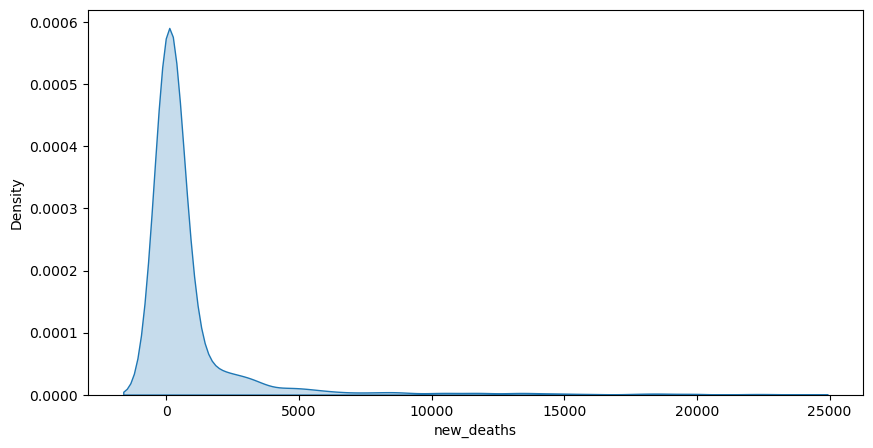

In [11]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='new_deaths', fill=True, label='Density Plot')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1000x500 with 0 Axes>

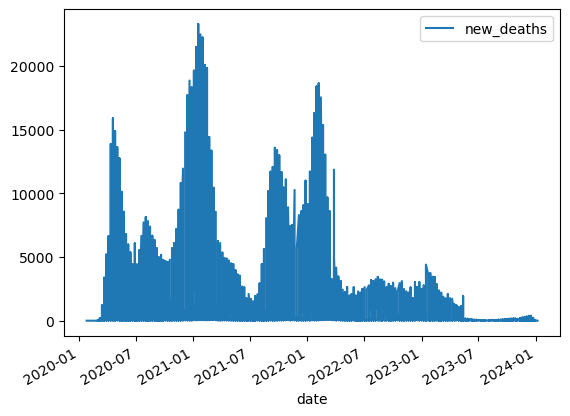

In [12]:
plt.figure(figsize=(10,5))
df.plot.line(x='date',y='new_deaths')
plt.show

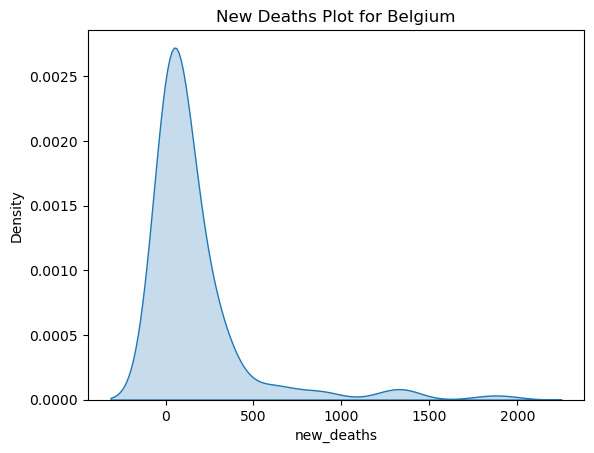

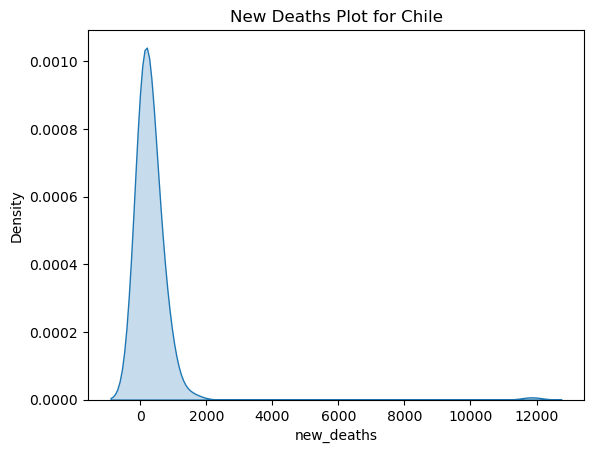

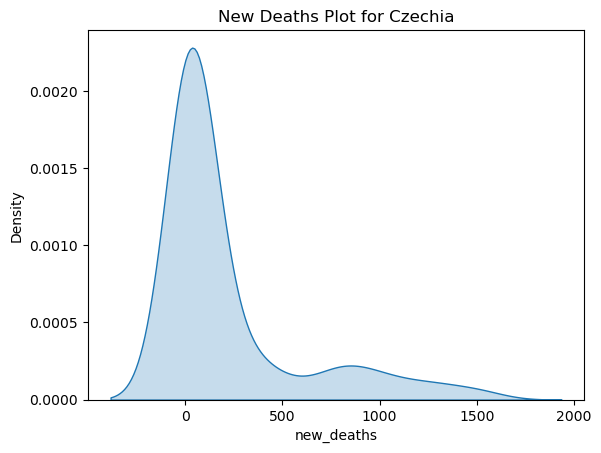

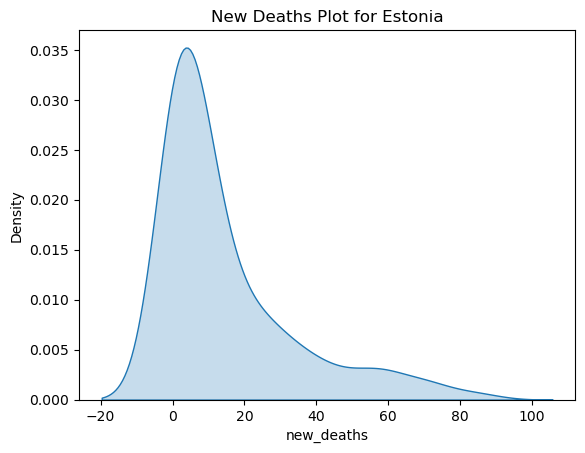

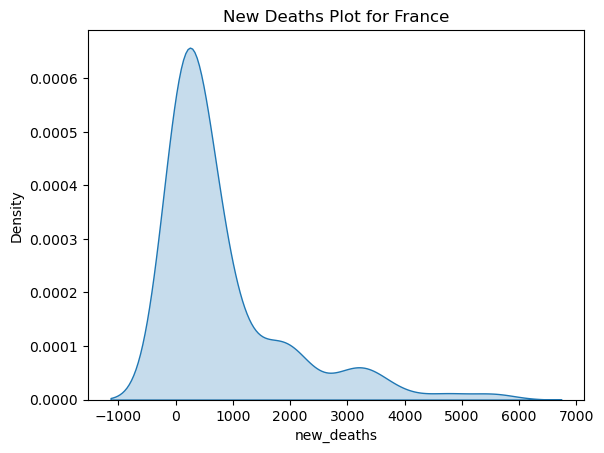

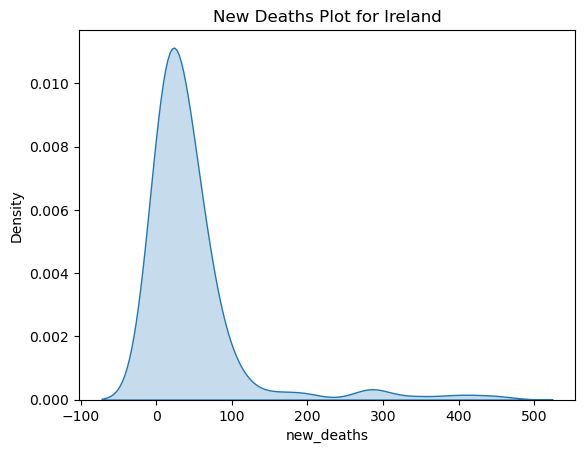

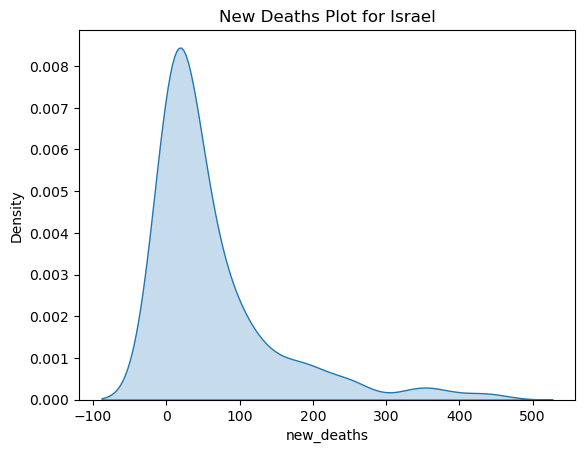

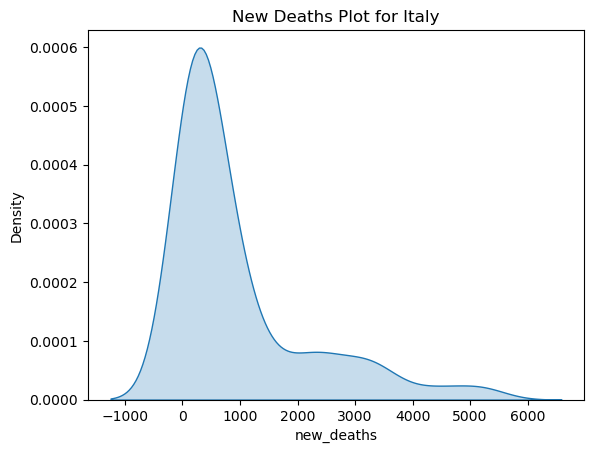

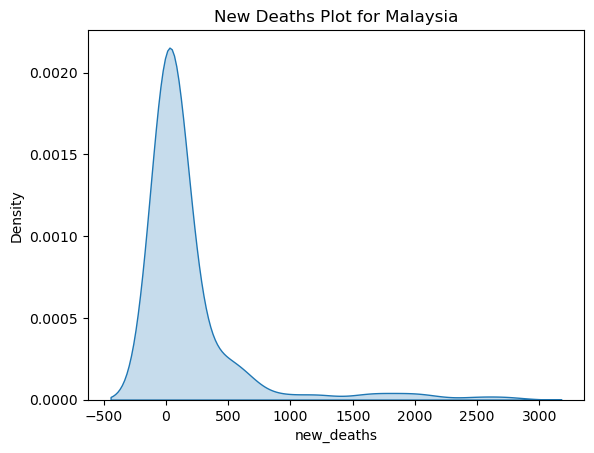

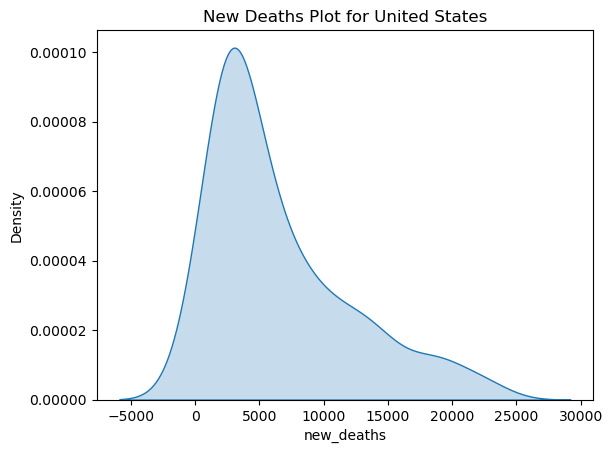

In [24]:
for country in df['location'].unique():
    country_data = df[df['location'] == country]
    sns.kdeplot(data=country_data, x='new_deaths', fill=True)
    plt.title(f'New Deaths Plot for {country}') 
    plt.show()


# The (Numeric) Predictors

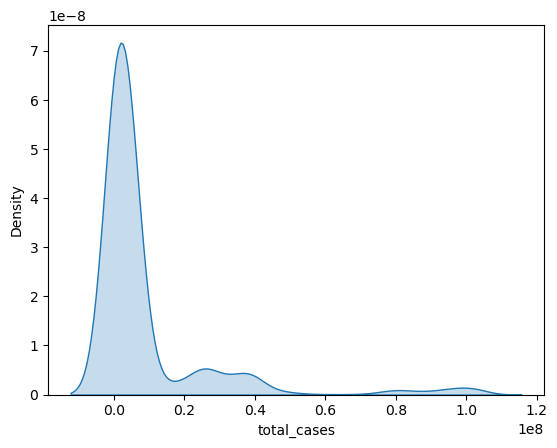

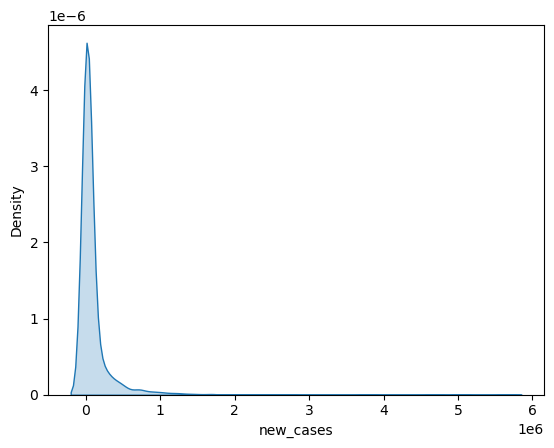

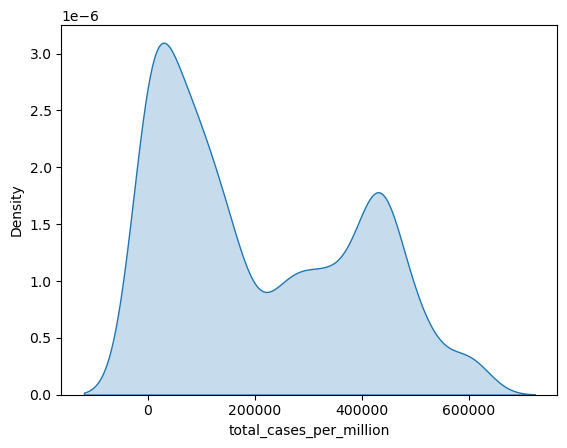

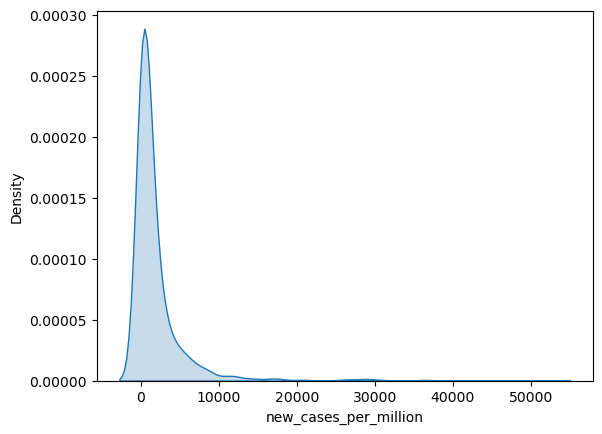

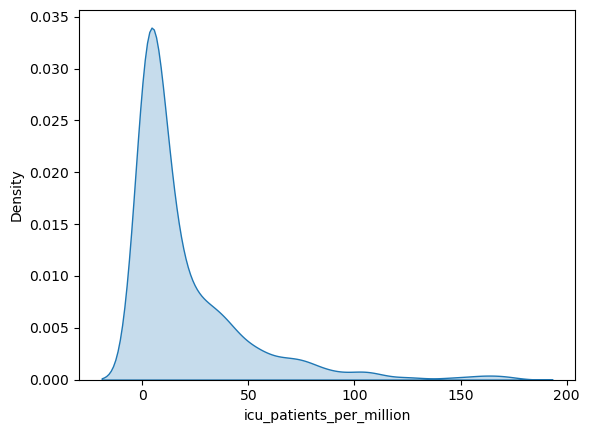

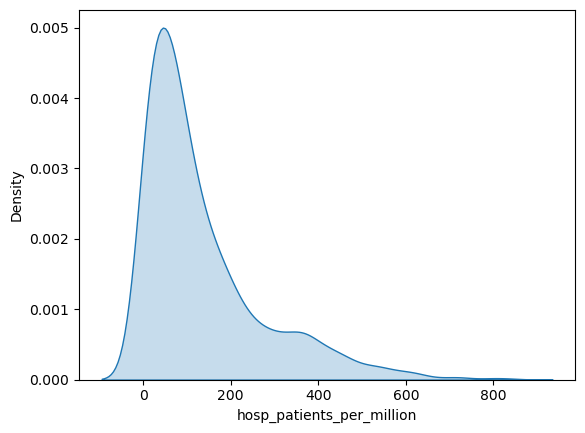

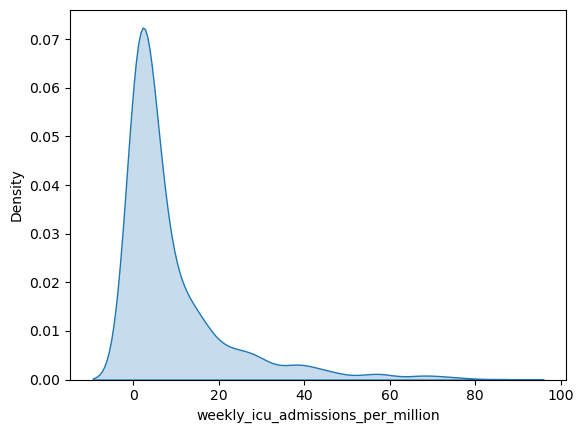

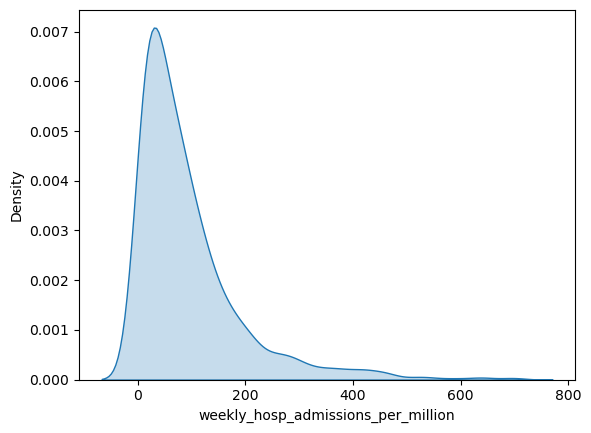

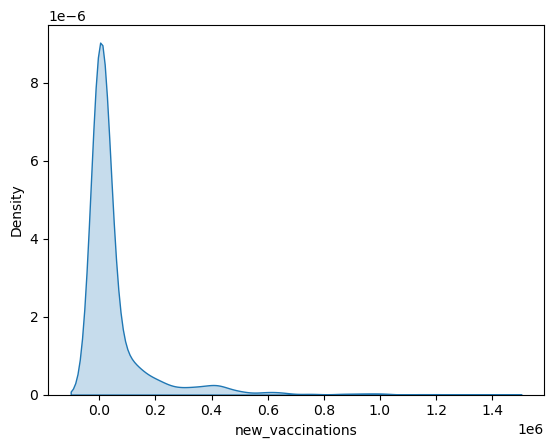

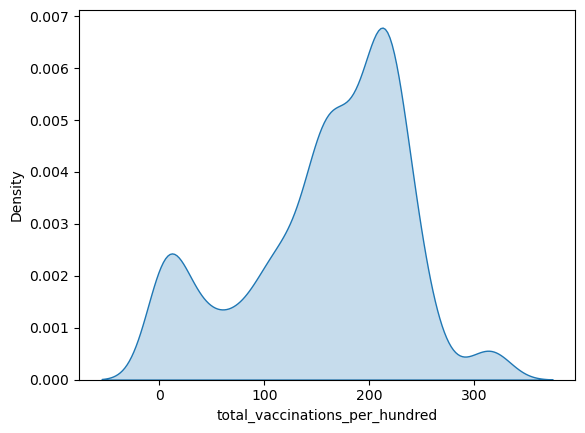

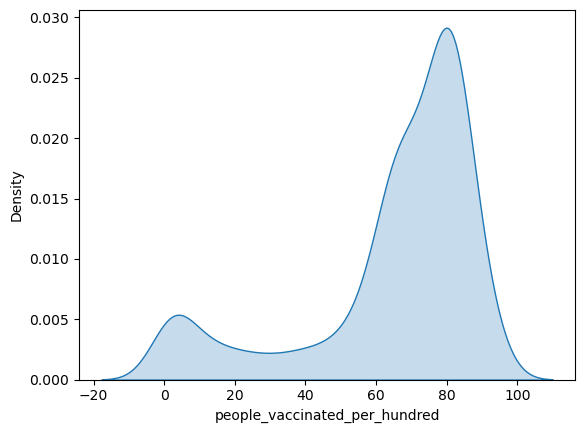

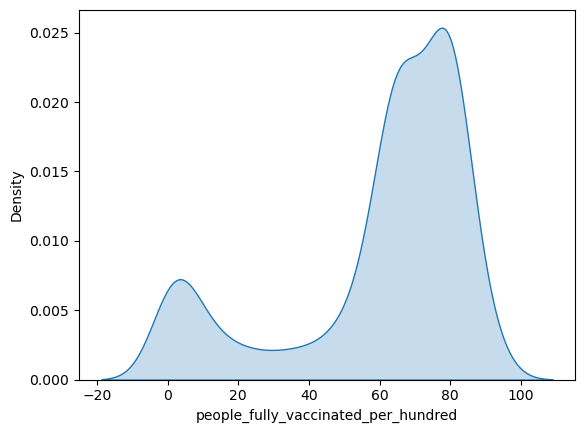

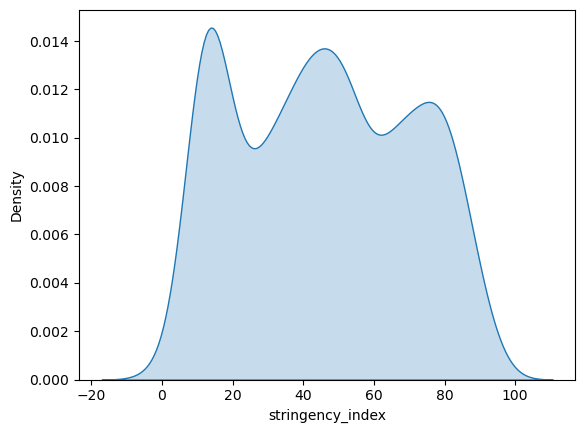

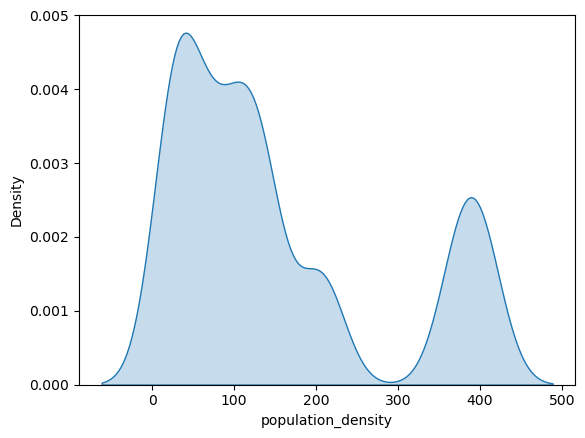

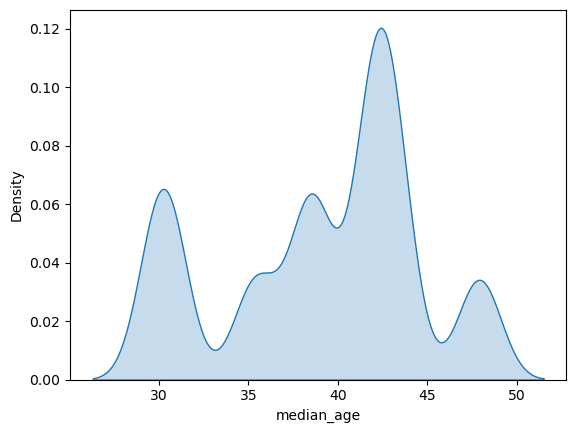

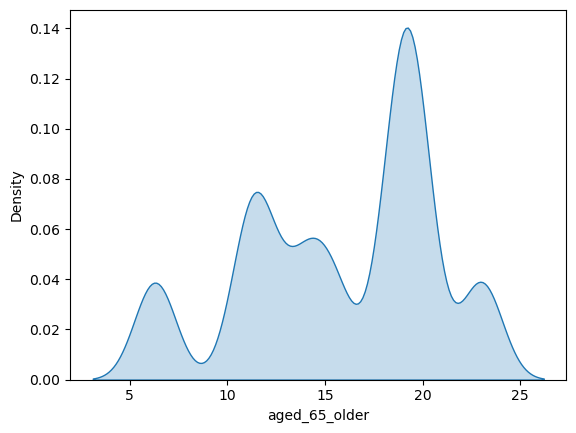

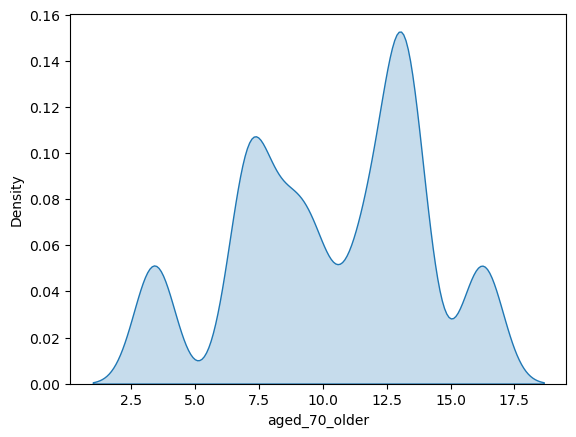

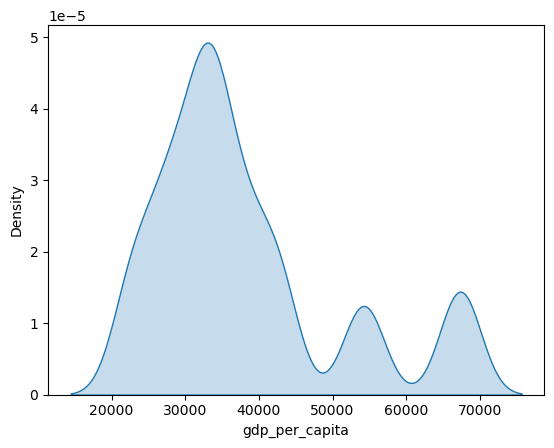

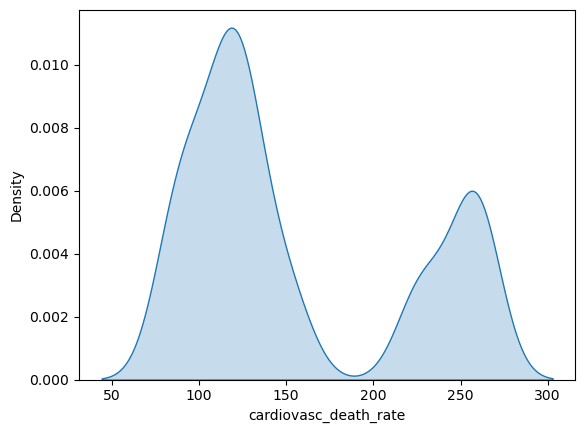

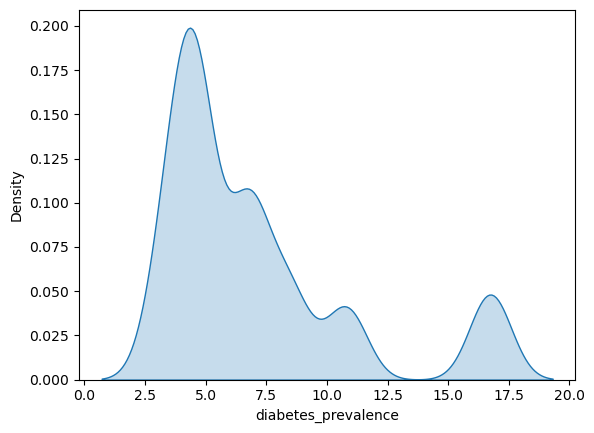

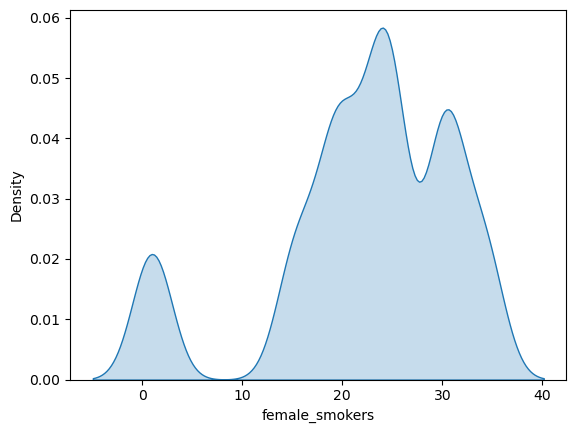

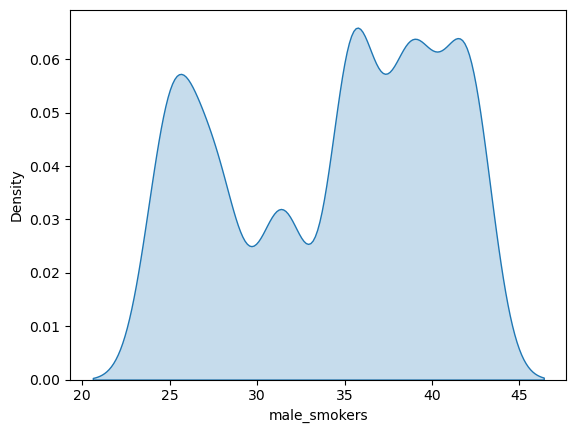

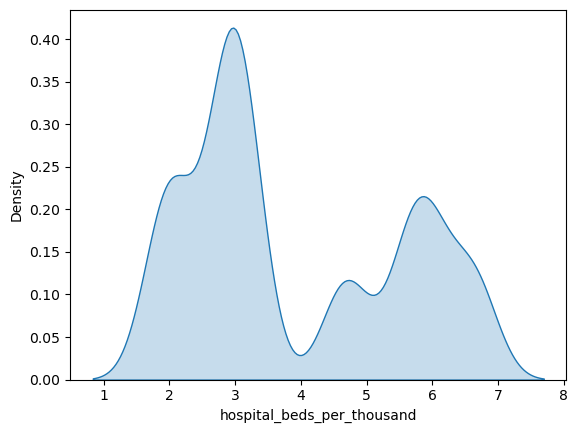

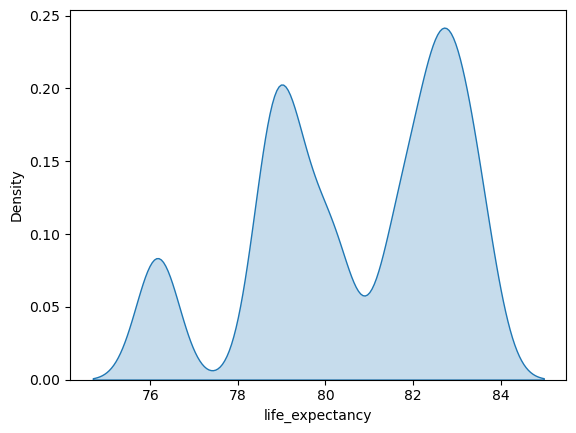

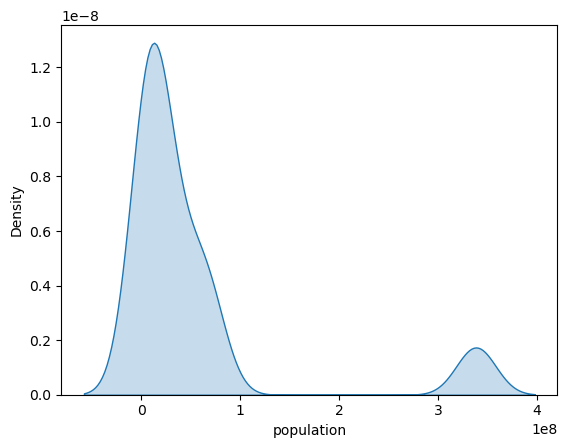

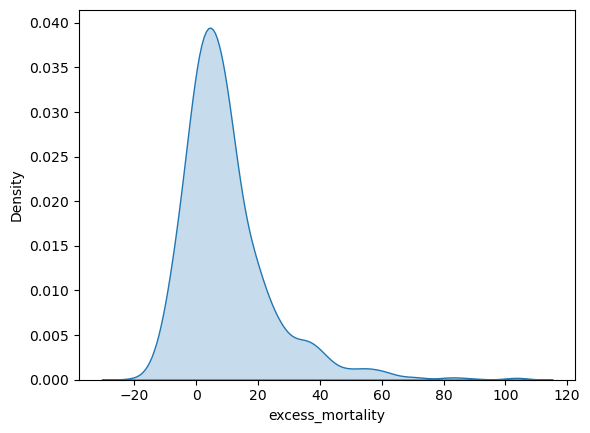

In [43]:
num_var = df.select_dtypes(include=['float64', 'int64']).columns
nontarget = [var for var in num_var if var != 'new_deaths']
for var in nontarget:
    sns.kdeplot(data=df, x=var, fill=True)
    plt.show()

# Correlations Among Predictors

In [44]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,population,excess_mortality
total_cases,1.000000,0.415566,0.350927,0.301492,0.022055,-0.064028,-0.023003,-0.117564,0.000078,0.252131,0.194886,0.229564,0.159741,-0.198333,-0.175981,0.096562,0.126015,0.109441,0.255262,-0.162831,0.145794,-0.016245,-0.382249,-0.062030,-0.024303,0.717038,-0.067415
new_cases,0.415566,1.000000,0.642166,-0.015104,0.413433,0.229137,0.279345,0.203255,0.320505,0.366236,-0.000612,0.033475,0.001586,0.004288,-0.131390,0.057125,0.076106,0.064293,0.189489,-0.101519,0.112741,-0.019940,-0.276843,-0.058448,-0.034374,0.519759,0.176917
new_deaths,0.350927,0.642166,1.000000,-0.168407,0.092862,0.338267,0.287799,0.461244,0.305290,0.548846,-0.217326,-0.198599,-0.220114,0.214413,-0.196253,0.034489,0.044958,0.028764,0.262575,-0.069508,0.192331,-0.052617,-0.372662,-0.136501,-0.119298,0.711513,0.300388
total_cases_per_million,0.301492,-0.015104,-0.168407,1.000000,0.037945,-0.390395,-0.088426,-0.343057,-0.110857,-0.296158,0.605222,0.497624,0.532659,-0.722232,0.150144,0.165171,0.236417,0.225759,0.006636,-0.120780,-0.267859,0.180625,-0.027888,0.266565,0.216691,-0.098368,-0.233509
new_cases_per_million,0.022055,0.413433,0.092862,0.037945,1.000000,0.230647,0.473047,0.272852,0.515201,0.009609,0.048575,0.047830,0.056020,-0.084783,0.052592,0.073361,0.103265,0.099840,0.012798,-0.064790,-0.103776,0.070042,-0.031484,0.097277,0.094767,-0.008098,0.219431
icu_patients_per_million,-0.064028,0.229137,0.338267,-0.390395,0.230647,1.000000,0.846243,0.949422,0.659606,0.155658,-0.525898,-0.509615,-0.527436,0.558340,-0.068072,0.045905,0.043692,0.031633,-0.058985,-0.148340,-0.044318,0.278590,0.035706,0.079403,0.043489,0.099993,0.644168
hosp_patients_per_million,-0.023003,0.279345,0.287799,-0.088426,0.473047,0.846243,1.000000,0.860815,0.838552,0.088787,-0.401823,-0.455598,-0.416032,0.289426,-0.019565,0.246702,0.282201,0.276532,-0.064967,-0.115569,-0.171075,0.257755,0.001901,0.262144,0.131212,0.039882,0.642528
weekly_icu_admissions_per_million,-0.117564,0.203255,0.461244,-0.343057,0.272852,0.949422,0.860815,1.000000,0.738604,0.050300,-0.504981,-0.525514,-0.519597,0.493872,-0.144747,0.012808,-0.012924,-0.029565,-0.218588,0.004651,0.240824,0.332332,0.261046,0.109269,-0.135979,0.124547,0.639027
weekly_hosp_admissions_per_million,0.000078,0.320505,0.305290,-0.110857,0.515201,0.659606,0.838552,0.738604,1.000000,0.153584,-0.381385,-0.401141,-0.376147,0.222615,-0.099141,0.047927,0.046289,0.023948,-0.025598,0.147722,0.049380,0.046926,0.052625,0.128311,-0.140561,0.091441,0.644117
new_vaccinations,0.252131,0.366236,0.548846,-0.296158,0.009609,0.155658,0.088787,0.050300,0.153584,1.000000,-0.270374,-0.179020,-0.253433,0.327924,-0.132133,0.000153,0.008878,0.000797,0.214583,-0.061808,0.216994,-0.155412,-0.338261,-0.195513,-0.090773,0.587191,0.065391


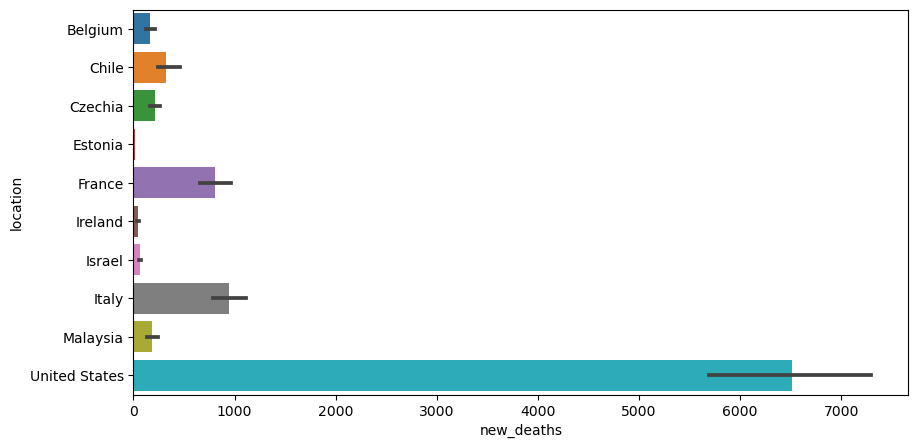

In [45]:
# Outliers Visualization

plt.figure(figsize=(10, 5))
sns.barplot(data=data, x='new_deaths', y="location", fill=True, label='Density Plot')
plt.show()

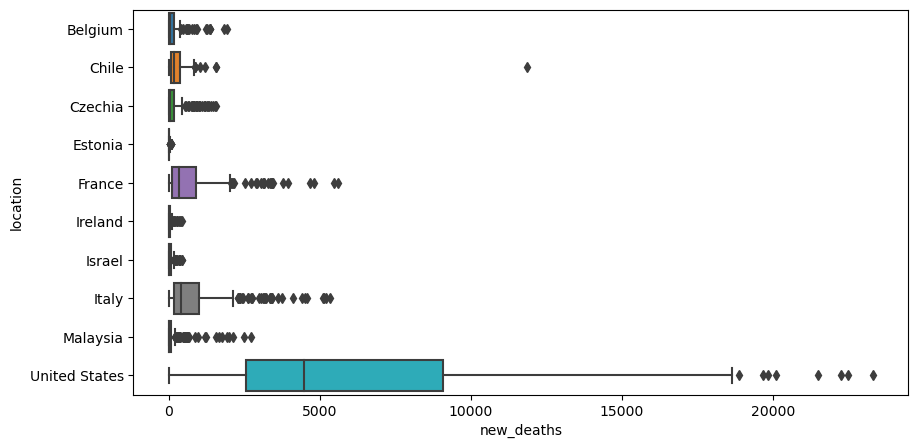

In [46]:

plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='new_deaths', y="location")
plt.show()

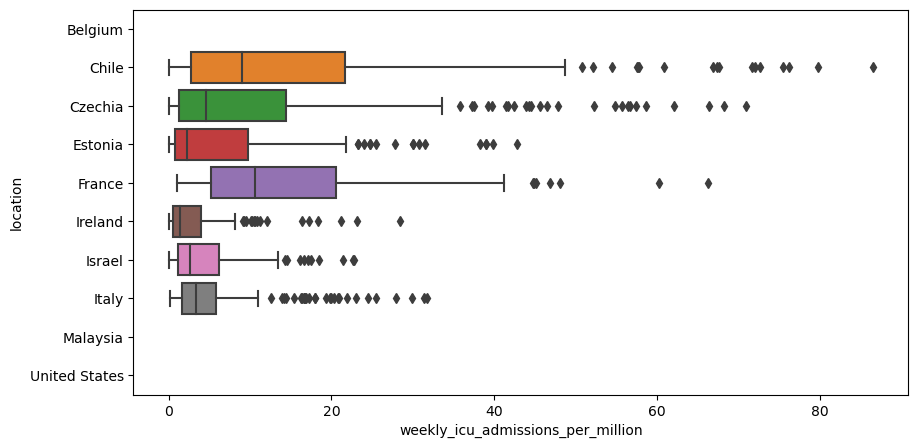

In [47]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='weekly_icu_admissions_per_million', y="location")
plt.show()

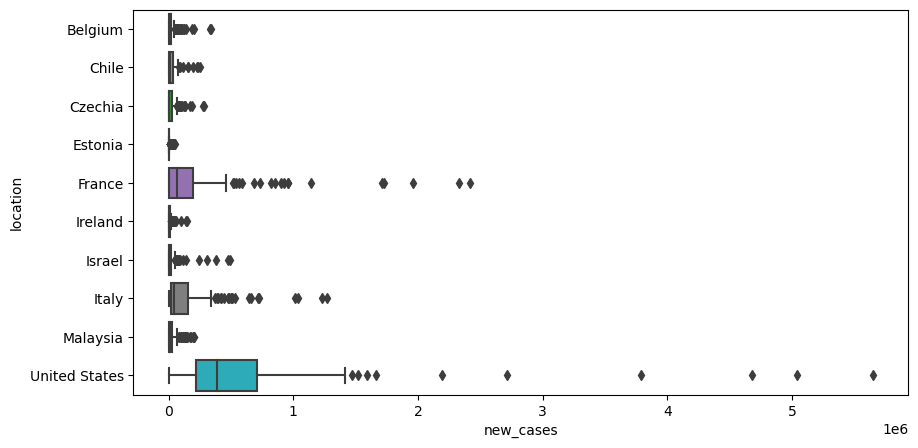

In [48]:
#new cases
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='new_cases', y="location")
plt.show()

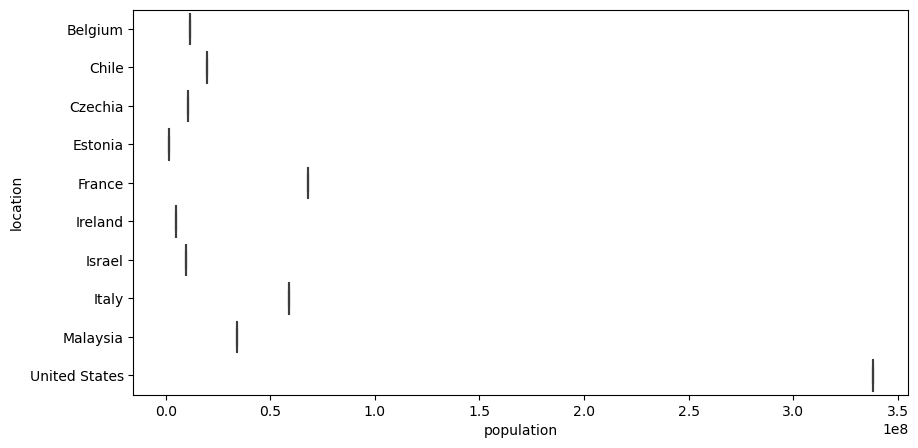

In [49]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='population', y="location")
plt.show()

# Correlation Analysis

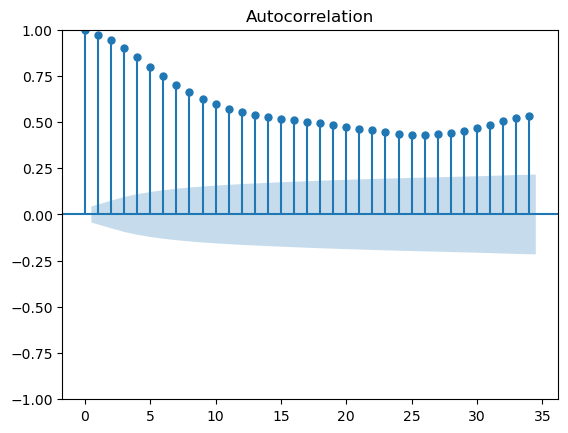

In [50]:
plot_acf(df['new_deaths'])
plt.show()

In [51]:
#plot_pacf(df['new_deaths'])
#plt.show()

# Temporal Analysis

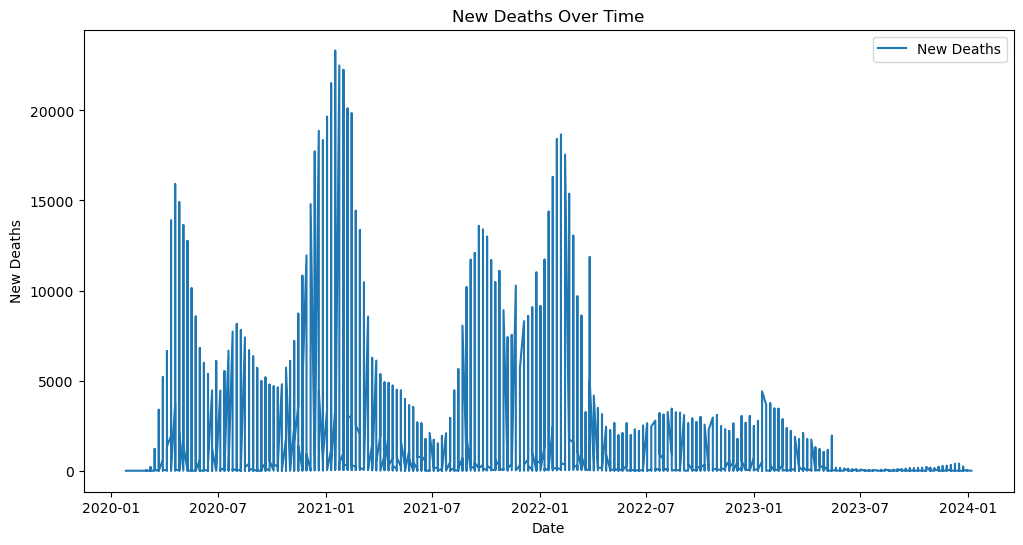

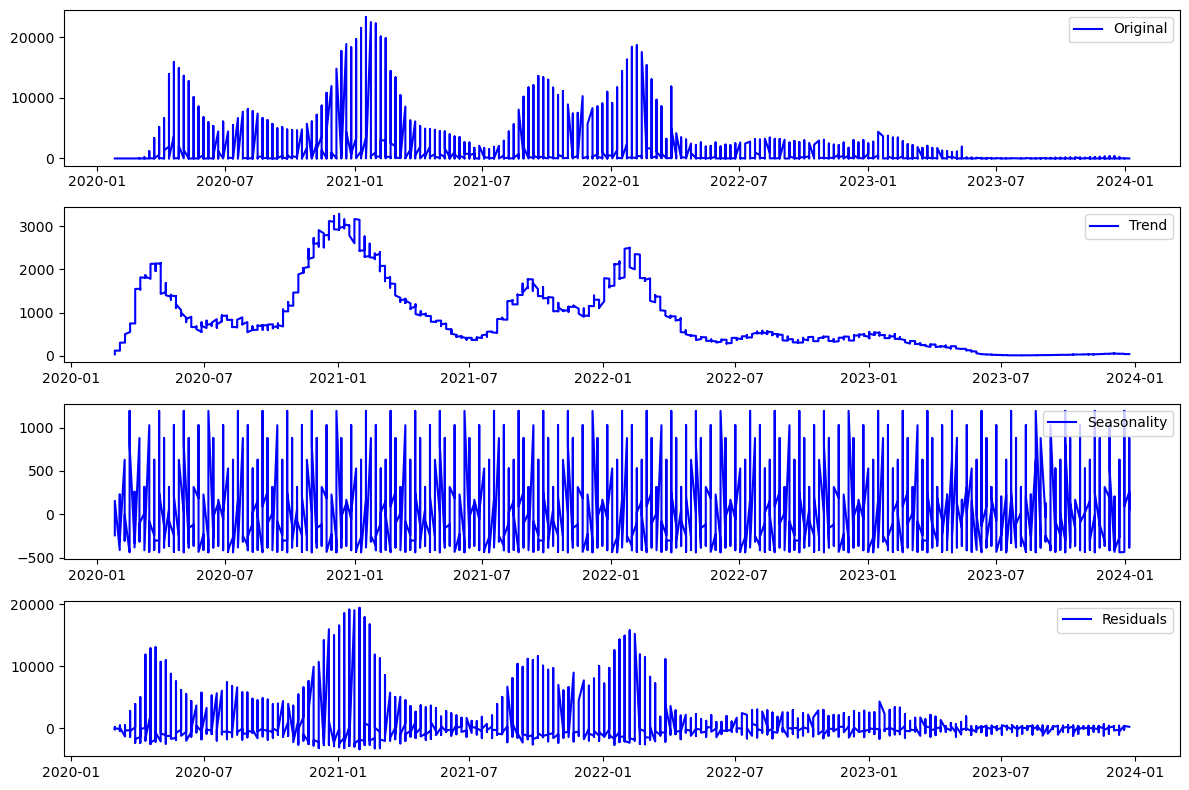

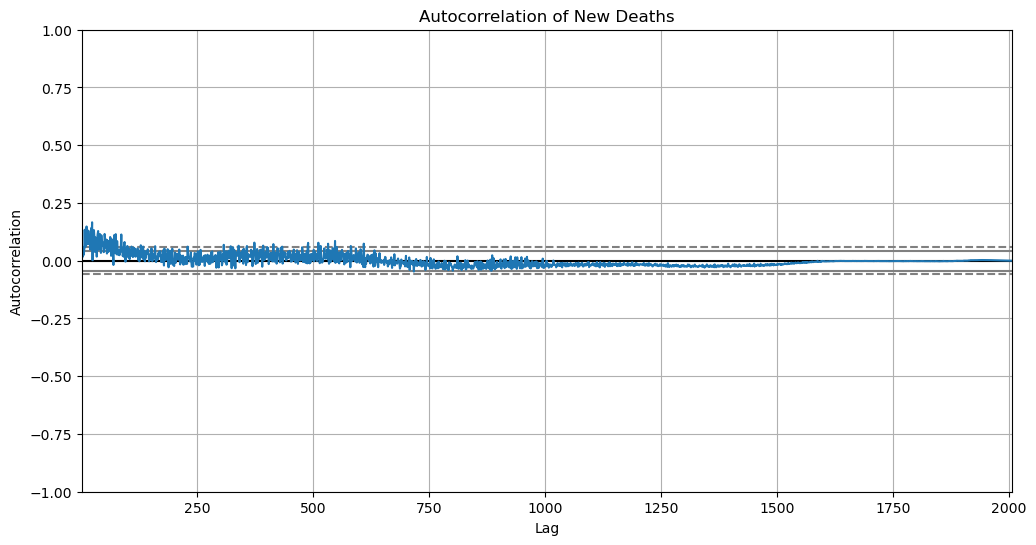

In [53]:
from pandas.plotting import autocorrelation_plot

df.set_index('date', inplace=True)

df.sort_index(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df['new_deaths'], label='New Deaths')
plt.title('New Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['new_deaths'], model='additive', period=52) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['new_deaths'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

plt.figure(figsize=(12, 6))
autocorrelation_plot(df['new_deaths'])
plt.title('Autocorrelation of New Deaths')
plt.show()


clear spikes in the number of new deaths over time, suggesting periodic outbreaks or waves of increased fatalities. 

there is a significant trend component, which indicates that there are long-term changes in the number of new deaths over time. the seasonal component is noisy, which could suggest that there is some form of seasonality, but it's not very regular or it's being influenced by other factors. the residuals plot reveals that there is a lot of unexplained variability in the data after accounting for the trend and seasonality.

the autocorrelation plot does not display clear, strong periodic spikes, which suggests that the seasonality is not very strong or consistent. 

In [54]:
## lag analysis

max_lag = 52  
for lag in range(1, max_lag + 1):
    df[f'lag_{lag}'] = df['new_deaths'].shift(lag)

correlation_with_lags = df.corr()['new_deaths'].sort_index(ascending=False)

print(correlation_with_lags[1:max_lag + 1])  

weekly_hosp_admissions_per_million     0.305290
total_vaccinations_per_hundred        -0.217326
total_cases_per_million               -0.168407
total_cases                            0.350927
stringency_index                       0.214413
population_density                    -0.196253
population                             0.711513
people_vaccinated_per_hundred         -0.198599
people_fully_vaccinated_per_hundred   -0.220114
new_vaccinations                       0.548846
new_deaths                             1.000000
new_cases_per_million                  0.092862
new_cases                              0.642166
median_age                             0.034489
male_smokers                          -0.372662
life_expectancy                       -0.119298
lag_9                                  0.081119
lag_8                                  0.058124
lag_7                                  0.134098
lag_6                                  0.044714
lag_52                                 0

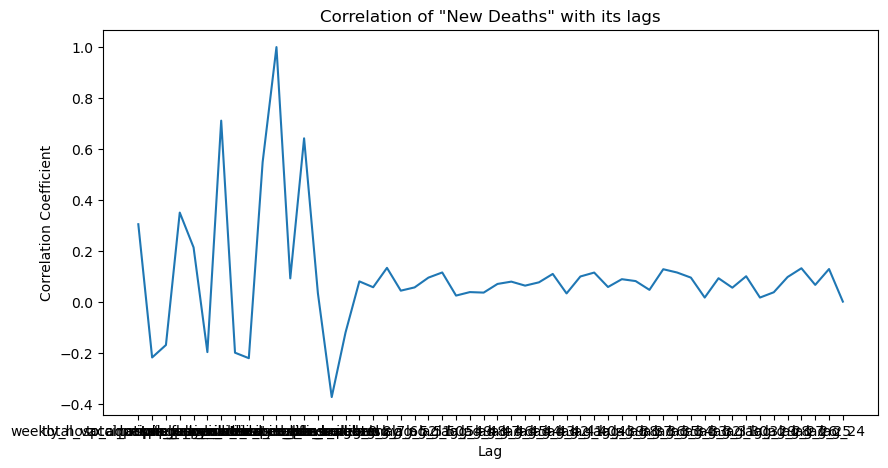

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(correlation_with_lags[1:max_lag + 1])
plt.title('Correlation of "New Deaths" with its lags')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.show()

/Users/nbirova/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/nbirova/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


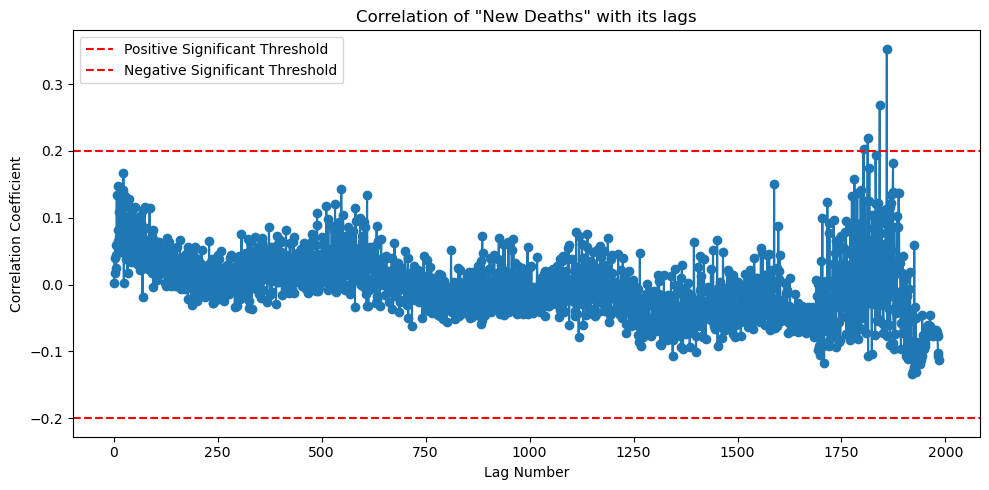

In [67]:
max_lag = 2007
significant_threshold = 0.2  # weeks in data set
lag_correlations = {}

for lag in range(1, max_lag + 1):
    df[f'lag_{lag}'] = df['new_deaths'].shift(lag)
    correlation = df['new_deaths'].corr(df[f'lag_{lag}'])
    lag_correlations[lag] = correlation

significant_lags = {lag: corr for lag, corr in lag_correlations.items() if abs(corr) > significant_threshold}

plt.figure(figsize=(10, 5))
plt.plot(list(lag_correlations.keys()), list(lag_correlations.values()), marker='o')
plt.axhline(y=significant_threshold, color='r', linestyle='--', label='Positive Significant Threshold')
plt.axhline(y=-significant_threshold, color='r', linestyle='--', label='Negative Significant Threshold')
plt.title('Correlation of "New Deaths" with its lags')
plt.xlabel('Lag Number')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.tight_layout()
plt.show()

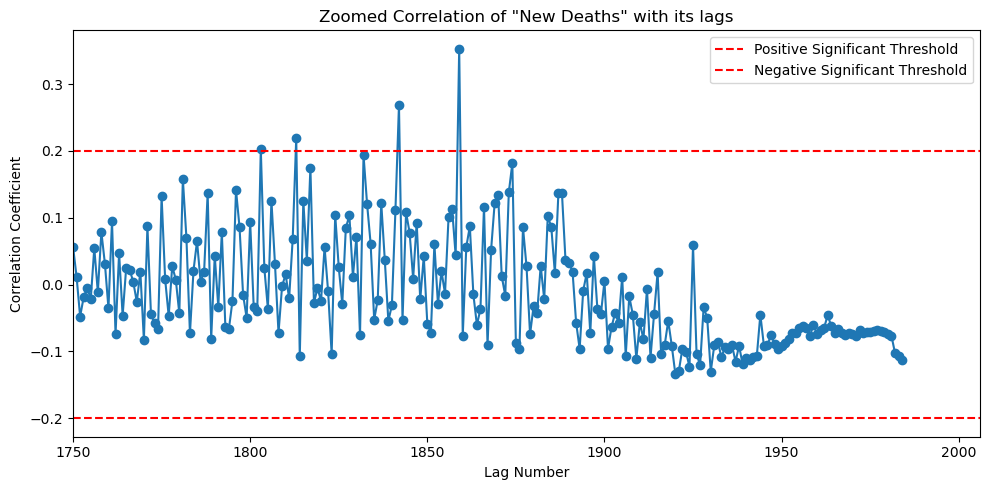

Significant lags and their correlations:
Lag 1803: Correlation 0.20
Lag 1813: Correlation 0.22
Lag 1842: Correlation 0.27
Lag 1859: Correlation 0.35


In [69]:
max_lag = 2007
significant_threshold = 0.2  
lag_correlations = {}

for lag in range(1750, max_lag + 1):
    df[f'lag_{lag}'] = df['new_deaths'].shift(lag)
    correlation = df['new_deaths'].corr(df[f'lag_{lag}'])
    lag_correlations[lag] = correlation

significant_lags = {lag: corr for lag, corr in lag_correlations.items() if abs(corr) > significant_threshold}

plt.figure(figsize=(10, 5))
plt.plot(list(lag_correlations.keys()), list(lag_correlations.values()), marker='o')
plt.axhline(y=significant_threshold, color='r', linestyle='--', label='Positive Significant Threshold')
plt.axhline(y=-significant_threshold, color='r', linestyle='--', label='Negative Significant Threshold')

plt.xlim(1750, 2006) 

plt.title('Zoomed Correlation of "New Deaths" with its lags')
plt.xlabel('Lag Number')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.tight_layout()
plt.show()

print("Significant lags and their correlations:")
for lag, corr in significant_lags.items():
    print(f"Lag {lag}: Correlation {corr:.2f}")